In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *


from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, LabelEncoder #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix


## 0. Together

Decision Trees are a (typically) classification algorithm that makes decisions by iteratively splitting data into groups until a classification is made. The resulting splits make what is essentially a flow chart. These trees are made one split at a time, and each split is chosen by minimizing the chaos (entropy or impurity) at that particular split.

### 0.1 Building a Decision Tree

In [2]:
d = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")

In [3]:
predictors = ["Pregnancies","Glucose","BloodPressure","SkinThickness",
              "Insulin","BMI","DiabetesPedigreeFunction","Age"]
X = d[predictors]
y = d["Outcome"]

# TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1234)

d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
tree = DecisionTreeClassifier(random_state = 1234)
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

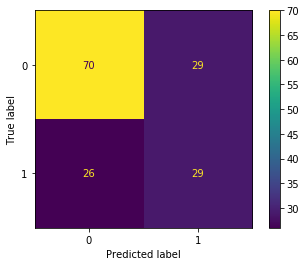

In [5]:
plot_confusion_matrix(tree, X_test, y_test)

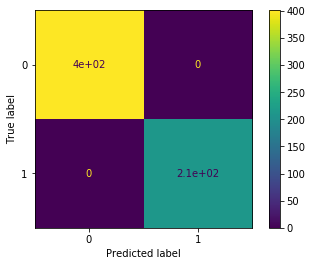

In [6]:
plot_confusion_matrix(tree, X_train, y_train)

### 0.2 What does this tell us?

And how can we fix things?
<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [7]:
# new model
tree.get_depth()

13

## 1. Pruning

It's your favorite time! Time to simulate some data.

### 1.1 Simulation

add the necessary code.

In [8]:
def simTree(n = 200, max_depth = "none"):
    
    n2 = int(n/2)
    
    #---generate data-----------------------------------
    # generate predictors, only x1 and x2 are related to the outcome
    x1 = np.concatenate([np.random.normal(0,1,n2),
                         np.random.normal(2,1,n2)])
    x2 = np.random.normal(0,1,n)
    x3 = np.concatenate([np.random.binomial(1,0.2,n2),
                        np.random.binomial(1,0.9, n2)])
    
    # generate outcome
    outcome = np.repeat(["A","B"], n2)
    
    # data frame
    df = pd.DataFrame({"x1": x1, "x2" : x2, "x3": x3, "out": outcome})
    
    #---set X and y------------------------------------
    X = df[["x1","x2","x3"]]
    y = df[["out"]]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

    
    #---build models------------------------------------
    
    # if there is no max depth, build regular tree
    if max_depth == "none":
        tree = DecisionTreeClassifier() 
        
    # otherwise, set max_depth
    else:
        tree = DecisionTreeClassifier(max_depth = max_depth)
        
    tree.fit(X_train,y_train)
    
    
    #---get training and test Accuracy---------------------
    train_acc = accuracy_score(y_train,tree.predict(X_train))
    test_acc = accuracy_score(y_test,tree.predict(X_test))
    
    return(pd.DataFrame({"Set": ["Train", "Test",],
                        "Depth": [str(max_depth), str(max_depth)],
                        "Acc": [train_acc,
                               test_acc]}))
    
    

In [9]:
sims = [simTree(n = 2000, max_depth = x) for x in np.repeat(range(2,10), 100)]
sims = sims + [simTree(n = 2000, max_depth = "none") for i in range(0,100)]
sims_df = pd.concat(sims)

sims_df.head()

,Set,Depth,Acc
0,Train,2,0.89375
1,Test,2,0.88250
0,Train,2,0.85625
1,Test,2,0.86250
0,Train,2,0.92375


### 1.2 Plotting it!
Now that we've run our simulation, use the `sims_df` data frame to make a plot that shows us the difference between the train and test accuracy for our full (not limited) and pruned (has a max_depth) trees. 

Use `geom_boxplot()` to plot Acc for each Tree `Depth`. Fill by Set.

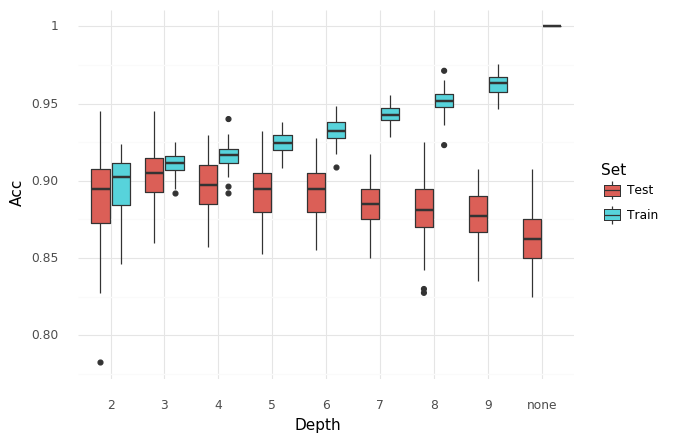

<ggplot: (8790891668345)>

In [10]:
### YOUR CODE HERE ###

(ggplot(sims_df, aes(x = "Depth", y = "Acc", fill = "Set")) + geom_boxplot() +
theme_minimal())

### *Question*

What does this graph tell you about how setting max_depth affects overfitting?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


### *Question*

If you reduce the number of data points in the sample (by change the `n` argument to 200 in `simTree()`), what changes? Why do you think these changes occur?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


In this example, we can see that as we go from NO LIMITS ("none") to stronger limits on max_depth, the difference between the training and test accuracy gets smaller, which indicates less concern for overfitting.

When you have fewer samples 1) there is a wider range of test accuracies and more variability. This is likely due to the fact that smaller samples are more variable than large samples. (OTHER ANSWERS FOR THIS ARE OKAY TOO).


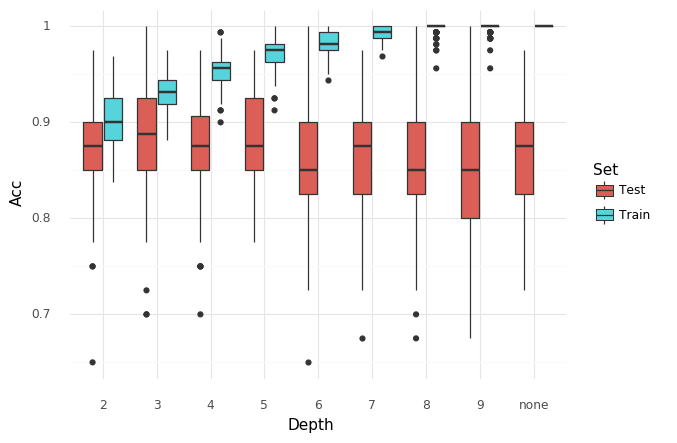

<ggplot: (8790891574477)>

In [11]:
sims = [simTree(n = 200, max_depth = x) for x in np.repeat(range(2,10), 100)] ### Change n
sims = sims + [simTree(n = 200, max_depth = "none") for i in range(0,100)]    ### Change n
sims_df = pd.concat(sims)

# make same plot as above

(ggplot(sims_df, aes(x = "Depth", y = "Acc", fill = "Set")) + geom_boxplot() +
theme_minimal())

# Gini Impurity

Use python and numpy to write a function, `gini()` that takes in 4 values `LNP`, `LNN`, `RNP`, `RNN` (LN = left node, RN = right node, P is for positive/1, N is for negative/0) and returns the gini impurity for that split.

<img src="https://drive.google.com/uc?id=1MQEeJDxxcV8zmhzBgaDZ2QY0Ng8z8hz8" width=400/>


In [12]:
import numpy as np

def gini(P,N):
    Total = P + N # total count in Node
    P_p = P/Total # Probability of Positives
    N_p = N/Total # Probability of Negatives
    return(1-(P_p**2 + N_p**2))

#write function here---------------
def gini_split(LNP, LNN, RNP, RNN):
    
    all_data_count = LNP + LNN + RNP + RNN
    left_node_count = LNP + LNN
    right_node_count = RNP + RNN
    
    gini_L =  gini(LNP, LNN) #gini on Left Node
    gini_R = gini(RNP, RNN) #gini on Right node
    
    gini_split = ((left_node_count/all_data_count)*gini_L +
            (right_node_count/all_data_count)*gini_R) #weighted average of gini impurity of each node
    
    return(gini_split)

gini_split(LNP = 10, LNN = 5, RNP = 2, RNN = 12)
#----------------------------------
# gini(LNP = 10, LNN = 5, RNP = 2, RNN = 12) should return approx 0.3481117

0.34811165845648606

In [14]:
def entropy(P,N):
    Total = P + N # total count in Node
    P_p = P/Total # Probability of Positives
    N_p = N/Total # Probability of Negatives
    return(-(P_p*np.log2(P_p) + N_p*np.log2(N_p)))
    
    
def entropy_split(LNP, LNN, RNP, RNN):
    
    all_data_count = LNP + LNN + RNP + RNN
    left_node_count = LNP + LNN
    right_node_count = RNP + RNN

    e_L = entropy(LNP,LNN) #entropy Left Node
    e_R = entropy(RNP,RNN) #entropy Right Node
    
    e = ((left_node_count/all_data_count)*e_L +
         (right_node_count/all_data_count)*e_R) #weighted average of entropy
    
    return(e)

    
entropy_split(LNP = 10, LNN = 5, RNP = 2, RNN = 12)
    

0.760615738309308

# 2. Build a Categorical Decision Tree

In [15]:
# Load Mushroom Data------------------------------------
import pandas as pd

# see this site for what variables mean: http://archive.ics.uci.edu/ml/datasets/Mushroom
mush = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")

mush.columns = ['poison','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size',
                'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
                'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number','ring-type',
                'spore-print-color', 'population', 'habitat']

mush.head()

,poison,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


For your sanity, let's restrict our dataset to 2 predictor variables...

In [16]:
mush_small = mush[["poison", "bruises", "gill-size"]]

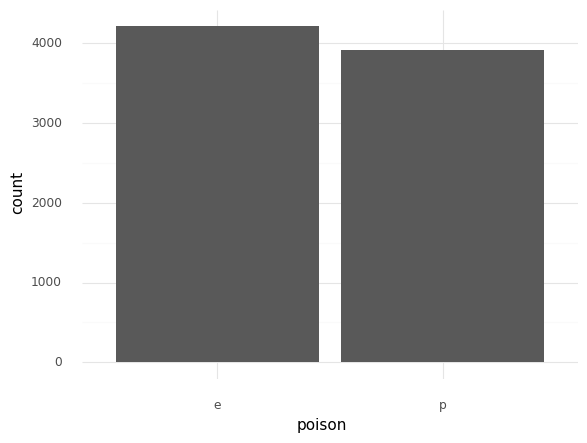

<ggplot: (8790885606644)>


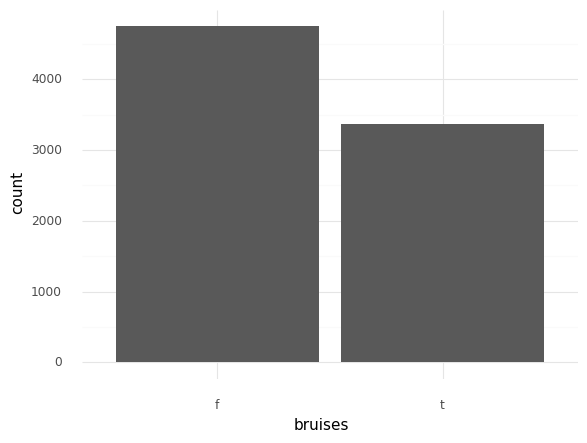

<ggplot: (8790891964841)>


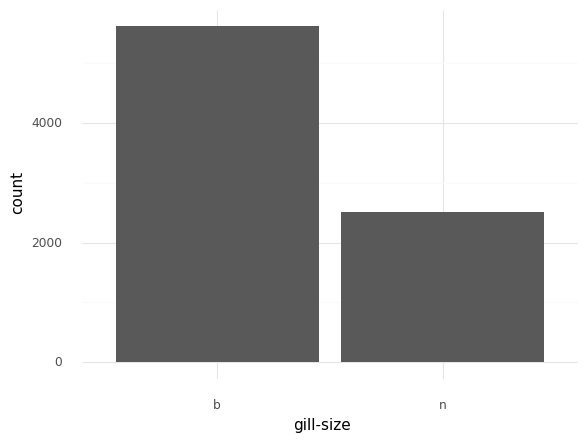

<ggplot: (8790892835280)>


In [17]:
# make a bar plot of edible/poisonous mushrooms
from plotnine import *
print(ggplot(mush_small, aes("poison")) + geom_bar() + theme_minimal())

# make a bar plot of bruised/not-bruised mushrooms
print(ggplot(mush_small, aes("bruises")) + geom_bar() + theme_minimal())

# make a bar plot of broad/narrow gilled mushrooms
print(ggplot(mush_small, aes("gill-size")) + geom_bar() + theme_minimal())

## 2.1 Build!

Use the functions you built earlier to build a decision tree that classifies each data point as either edible (`e`) or poisonous (`p`). You can choose to either use entropy or gini impurity. 

### 2.1.1 Layer 1

Choose which variable to use to split the first layer

In [18]:
# create a dictionary of poison counts for each predictor---

poison_count = {"e": mush_small.loc[mush_small.poison == "e"].shape[0],
                "p": mush_small.loc[mush_small.poison == "p"].shape[0]}
print(poison_count)

gini(poison_count["e"], poison_count["p"])

{'e': 4208, 'p': 3915}


0.49934946249669365

In [19]:
# calculate impurity/entropy (choose one metric) of each possible split---
bruise_NodeF = mush_small.loc[mush_small.bruises == "f"] #node with bruise = F
bruise_NodeT = mush_small.loc[mush_small.bruises == "t"] #node with bruise = T

bruise_impurity_dict = {"f": {"e": bruise_NodeF[bruise_NodeF.poison == "e"].shape[0],
                              "p": bruise_NodeF.loc[bruise_NodeF.poison == "p"].shape[0]},
                        "t": {"e": bruise_NodeT[bruise_NodeT.poison == "e"].shape[0],
                              "p": bruise_NodeT.loc[bruise_NodeT.poison == "p"].shape[0]},}

bruise_impurity_dict

{'f': {'e': 1456, 'p': 3292}, 't': {'e': 2752, 'p': 623}}

In [20]:
gill_NodeB = mush_small.loc[mush_small["gill-size"] == "b"] #node with gill = b
gill_NodeN = mush_small.loc[mush_small["gill-size"] == "n"] #node with gill = n

gill_impurity_dict = {"b": {"e": gill_NodeB[gill_NodeB.poison == "e"].shape[0],
                              "p": gill_NodeB.loc[gill_NodeB.poison == "p"].shape[0]},
                        "n": {"e": gill_NodeN[gill_NodeN.poison == "e"].shape[0],
                              "p": gill_NodeN.loc[gill_NodeN.poison == "p"].shape[0]},}

gill_impurity_dict

{'b': {'e': 3920, 'p': 1692}, 'n': {'e': 288, 'p': 2223}}

In [21]:
# choose which split improves prediction most---
gini_bruise = gini_split(bruise_impurity_dict["f"]["e"], bruise_impurity_dict["f"]["p"],
                  bruise_impurity_dict["t"]["e"], bruise_impurity_dict["t"]["p"])
gini_bruise

0.37363252569361594

In [22]:
# gini_gill
gini_gill = gini_split(gill_impurity_dict["b"]["e"], gill_impurity_dict["b"]["p"],
                gill_impurity_dict["n"]["e"], gill_impurity_dict["n"]["p"])

gini_gill

0.3537695848523329

Splitting on Gill minimizes the gini impurity, so we will use this split.

### 2.1.3 Create Classifications

Pretend that this decision stump (a decision tree with only one layer) is your final tree. Generate the classification for each data point and store it in `mush_small`.

In [23]:
# classification---

# re define these, but they're also defined above!
gill_NodeB = mush_small.loc[mush_small["gill-size"] == "b"] #node with gill = b
gill_NodeN = mush_small.loc[mush_small["gill-size"] == "n"] #node with gill = n

gill_impurity_dict = {"b": {"e": gill_NodeB[gill_NodeB.poison == "e"].shape[0],
                              "p": gill_NodeB.loc[gill_NodeB.poison == "p"].shape[0]},
                        "n": {"e": gill_NodeN[gill_NodeN.poison == "e"].shape[0],
                              "p": gill_NodeN.loc[gill_NodeN.poison == "p"].shape[0]},}

gill_impurity_dict

# these are our two nodes from this decision stump.
# check which category we should classify each node as:
# NodeB has more edible mushrooms, we we'll classify all data points in this node as edible
# NodeN has more poisonous mushrooms, we we'll classify all data points in this node as poison


# add classifications to dataframe
mush_small["class"] = ["e" if x == "b" else "p" for x in mush_small["gill-size"]]

### 2.1.4 Calculate Accuracy

Count how often your model was correct. How well did your model do?

In [24]:
# accuracy----
np.mean(mush_small["poison"] == mush_small["class"])

0.7562476917395051